<a href="https://colab.research.google.com/github/vanderbilt-ml/51-assign05-BRay/blob/main/bray_employee_churn_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning using scikit-learn**

As a reminder, below are the following best practices we should follow when performing Machine Learning in Python:

1. Perform all pre-processing steps within cross-validation
2. Measure model performance (and model selection) using cross-validation
3. Follow literate programming practices to make code readable and make collaboration easier

## Problem Formulation

In this example, we will use IBM's HR Attrition dataset, available here: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset.
The dataset contains data on 1470 employees. The variables covered in this dataset focus heavily on demographic attributes (e.g. gender, age and race), social related attributes (e.g. marital status) and work related attributes (e.g. tenure and pay).

In [1058]:
#tables and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#machine learning
from sklearn.ensemble import GradientBoostingClassifier, RandomTreesEmbedding #Gradient Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Load Data

Here we first load the data into python using pandas and read it in as a pandas dataframe which is the format which we will use throughout the example. 

In [1059]:
employee_df = pd.read_excel('IBM-HR-Data-Employee-Attrition.xlsx')
display(employee_df.head())
employee_df.info()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [1060]:
employee_df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

## Data cleaning and EDA

We can now briefly explore our data. For now, we can observe that there are a zero NA values which will likely need imputation. We'll wait for this step so that we can put it within our training loop in case future data sets from IBM HR might have NA values. You are welcome to explore additional aspects of the data and build out 2-3 features on your own

In [1061]:
employee_df = employee_df.dropna(subset=['Attrition'])
employee_df.shape

(1470, 35)

In [1062]:
class_column = 'Attrition'
random_seed = 2435

X_train, X_test, y_train, y_test = train_test_split(employee_df.drop(columns=class_column), employee_df[class_column],
                                                   test_size=0.25, random_state=random_seed, stratify=employee_df[class_column])

Quick sanity check to make sure that everything seems correct:

In [1063]:
# X Train
print('On X train: ')
print('X train dimensions: ', X_train.shape)
display(X_train.head())

# X test
print('\nOn X test: ')
print('X test dimensions: ', X_test.shape)
display(X_test.head())

On X train: 
X train dimensions:  (1102, 34)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1331,48,Travel_Rarely,1224,Research & Development,10,3,Life Sciences,1,1867,4,...,4,80,0,29,3,3,22,10,12,9
485,27,Travel_Rarely,798,Research & Development,6,4,Medical,1,655,1,...,3,80,2,6,5,2,5,3,0,3
1368,34,Travel_Frequently,735,Research & Development,22,4,Other,1,1932,3,...,2,80,0,16,3,3,15,10,6,11
579,34,Travel_Rarely,121,Research & Development,2,4,Medical,1,804,3,...,3,80,0,6,3,3,6,5,1,3
142,38,Travel_Rarely,364,Research & Development,3,5,Technical Degree,1,193,4,...,2,80,0,19,2,3,3,2,2,2



On X test: 
X test dimensions:  (368, 34)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
129,49,Travel_Rarely,470,Research & Development,20,4,Medical,1,170,3,...,3,80,0,16,2,2,15,11,5,11
1120,38,Travel_Rarely,437,Sales,16,3,Life Sciences,1,1583,2,...,2,80,0,8,5,4,3,2,1,2
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,...,3,80,0,8,3,3,8,7,3,0
965,25,Travel_Rarely,882,Research & Development,19,1,Medical,1,1358,4,...,3,80,3,7,6,2,3,2,1,2
94,32,Travel_Rarely,1093,Sales,6,4,Medical,1,125,2,...,1,80,0,12,0,3,11,8,5,7


In [1064]:
# X Train
print('On y train: ')
print('y train dimensions: ', y_train.shape)
display(y_train.head())

# X test
print('\nOn y test: ')
print('y test dimensions: ', y_test.shape)
display(y_test.head())

On y train: 
y train dimensions:  (1102,)


1331    No
485     No
1368    No
579     No
142     No
Name: Attrition, dtype: object


On y test: 
y test dimensions:  (368,)


129     No
1120    No
3       No
965     No
94      No
Name: Attrition, dtype: object

## Establish the training pipeline

We can now establish the training pipeline for our models. Since this is a process we would need to repeat several times, it's good to essentially functionalize the process so we do not need to re-write redundant code. Here, we can impute some values that were missing, and encode any categorical values. Note that these pipelines will change according to the model and methodology you choose - additionally, the pipelines will also change depending on the data types of the columns in your dataset. 

In [1065]:
# TODO: establish your own pipelines for the different data types
cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder())])
num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(strategy='mean')),
                               ('scale_num', StandardScaler())])



In [1066]:
# TODO: establish your preprocessing pipeline by your feature set
preprocess = ColumnTransformer([('cat_pipe', cat_pipeline, make_column_selector(dtype_include=object)),
                             ('num_pipe', num_pipeline, make_column_selector(dtype_include=np.number))],
                             remainder='passthrough')


LogisticRegression

In [1067]:
# TODO: set up your modeling pipeline
pipeLR = Pipeline(steps=[('preproc', preprocess),
                       ('mdl', LogisticRegression(penalty='elasticnet', solver='saga', tol=0.01))])


# Feel free to uncomment and edit the code below to visualize your overall pipeline
with config_context(display='diagram'):
    display(pipeLR)


Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0751427590>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0751427250>)])),
                ('mdl',
                 LogisticRegression(penalty='elasticnet', solver='saga',
                                    tol=0.01))])

RandomForest

In [1068]:
# TODO: set up your modeling pipeline RandomForest
pipeRandForest = Pipeline([('preproc', preprocess),
                        ('rf', RandomForestClassifier())])

# Feel free to uncomment and edit the code below to visualize your overall pipeline
with config_context(display='diagram'):
    display(pipeRandForest)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0751427590>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0751427250>)])),
                ('rf', RandomForestClassifier())])

GradientBoost

In [1069]:
# TODO: set up your modeling pipeline GradientBoosting
pipeGradBoost = Pipeline(steps=[('preproc', preprocess),
                       ('gbc', GradientBoostingClassifier())])


# Feel free to uncomment and edit the code below to visualize your overall pipeline
with config_context(display='diagram'):
    display(pipeGradBoost)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0751427590>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0751427250>)])),
                ('gbc', GradientBoostingClassifier())])

In [1070]:
# TODO: set up your modeling pipeline
#pipe = Pipeline(steps=[('preproc', preproc),
 #                     ('mdl', LogisticRegression(penalty='elasticnet', solver='saga', tol=0.01))])

pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', GradientBoostingClassifier())])

# pipe = Pipeline(steps=[('preproc', preproc),
#                        ('mdl', RandomForestClassifier())])


# Feel free to uncomment and edit the code below to visualize your overall pieline
with config_context(display='diagram'):
  display(pipe)


Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0753486910>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0753486b90>)])),
                ('mdl', GradientBoostingClassifier())])

## Cross-validation with hyperparameter tuning

Now that we have our pipelines, we can now use this as part of cross validation and hyperparameter tuning.

Logistic

In [1071]:
# TODO: set up your tuning grid 
# grid_search_lr.get_params().keys()
tuning_grid_lr = {'mdl__l1_ratio' : np.linspace(0,1,5),
                           'mdl__C': np.logspace(-1, 6, 3) }
grid_search_lr = GridSearchCV(pipeLR, param_grid = tuning_grid_lr, cv = 5, return_train_score=True)

Random Forest

In [1072]:
# TODO: set up your tuning grid
# grid_search_rf.get_params().keys()
tuning_grid_rf = param_grid = {'rf__n_estimators': [10, 50],
                                        'rf__max_features': ['auto', 'sqrt', 'log2'],
                                        'rf__max_depth' : [4,5,6],
                                        'rf__criterion' :['gini', 'entropy']
                                       }
grid_search_rf = GridSearchCV(pipeRandForest, param_grid = tuning_grid_rf, cv = 5, return_train_score=True)

Gradient Boosting

In [1073]:
# TODO: set up your tuning grid
# grid_search_gb.get_params().keys()
tuning_grid_gb = param_grid = {'gbc__learning_rate': [1, 0.5, 0.25],
                                       'gbc__n_estimators': [64, 128, 256],
                                       'gbc__max_depth': [2, 4],
                                       'gbc__min_samples_split': [2, 4]
                                      }
grid_search_gb = GridSearchCV(pipeGradBoost, param_grid = tuning_grid_gb, cv = 5, return_train_score=True)

In [1074]:
# TODO: fit your model
# Fit Logistic
grid_search_lr.fit(X_train, y_train)
# Fit RandomRainForest
grid_search_rf.fit(X_train, y_train)
# Fit Gradient Boosting
grid_search_gb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f0751427590>),
                                                                        ('num_pipe',
                                                                    

# Best performing model parameters

Random Forest

In [1075]:
# TODO: find the best performing model parameters and their values
print(grid_search.best_score_)
grid_search.best_params_

print("RandomForest best score:", grid_search_rf.best_score_)
grid_search_rf.best_params_

0.8566310160427808
RandomForest best score: 0.860275606746195


{'rf__criterion': 'entropy',
 'rf__max_depth': 6,
 'rf__max_features': 'auto',
 'rf__n_estimators': 10}

LogisticRegression

In [1076]:
print("LogisticRegression best score:", grid_search_lr.best_score_)
grid_search_lr.best_params_


LogisticRegression best score: 0.8784080625257096


{'mdl__C': 0.1, 'mdl__l1_ratio': 0.0}

GradientBoost

In [1077]:
print("Grid search GradientBoost best score:", grid_search_gb.best_score_)
grid_search_gb.best_params_

Grid search GradientBoost best score: 0.8575442204853969


{'gbc__learning_rate': 0.25,
 'gbc__max_depth': 2,
 'gbc__min_samples_split': 2,
 'gbc__n_estimators': 64}

## Final fit

The final fit here is already present in the generated model due to the way we set our parameters in the grid search. If we want to look at the performance, we can do so. Here is a non-helpful description of the best model:

Gradient Boost

In [1078]:
# TODO: print your best estimator (pipeline)
grid_search_gb.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f07519bdd50>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                

RandomForest

In [1079]:
# TODO: print your best estimator (pipeline)
grid_search_rf.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f07516fa0d0>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                

Logistic

In [1080]:
# TODO: print your best estimator (pipeline)
grid_search_lr.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0751962290>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                

## Variable importance

Now we assess the importance in the selected model to reveal any potential insights.

RandomForest

In [1081]:
# TODO: feel free to print out the target classes
grid_search_rf.classes_

array(['No', 'Yes'], dtype=object)

In [1082]:
# TODO: feel free to uncomment and edit the code below to obtain your feature weights

vip_rf = grid_search_rf.best_estimator_['rf']
vip_rf

RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=10)

In [1083]:
# TODO: feel free to uncomment and edit the code below to obtain your feature importance graph. 
# Did the graph surprise you? What features did you think were more important?

#get names in correct preproc order
cat_names = grid_search_rf.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names_out()
num_names = grid_search_rf.best_estimator_.named_steps['preproc'].transformers_[1][2]

#create df with vip info
#coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'vip': vip_rf})

#get sign and magnitude information
#coef_info = coef_info.assign(coef_mag = abs(coef_info['vip']),
                             #coef_sign = np.sign(coef_info['vip']))

#sort and plot
#coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
#plt.figure(figsize = (17,15))
#sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False)

Gradient

In [1084]:
# TODO: feel free to print out the target classes
grid_search_gb.classes_

array(['No', 'Yes'], dtype=object)

In [1085]:
# TODO: feel free to uncomment and edit the code below to obtain your feature weights

vip_gb = grid_search_gb.best_estimator_['gbc']
vip_gb

GradientBoostingClassifier(learning_rate=0.25, max_depth=2, n_estimators=64)

In [1086]:
# TODO: feel free to uncomment and edit the code below to obtain your feature importance graph. 
# Did the graph surprise you? What features did you think were more important?

#get names in correct preproc order
cat_names = grid_search_gb.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names_out()
num_names = grid_search_gb.best_estimator_.named_steps['preproc'].transformers_[1][2]

#create df with vip info
#coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'vip': vip_gb})

#get sign and magnitude information
#coef_info = coef_info.assign(coef_mag = abs(coef_info['vip']),
 #                            coef_sign = np.sign(coef_info['vip']))

#sort and plot
#coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
#plt.figure(figsize = (17,15))
#sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False)

Logistic

In [1087]:
# TODO: feel free to print out the target classes
grid_search_gb.classes_

array(['No', 'Yes'], dtype=object)

In [1088]:
# TODO: feel free to uncomment and edit the code below to obtain your feature weights

vip_lr = grid_search_lr.best_estimator_['mdl'].coef_[0]
vip_lr

array([-0.51138411,  0.3724124 , -0.15558804,  0.00493287, -0.37168697,
        0.07219434,  0.07420728, -0.2849673 ,  0.05309033, -0.18404841,
       -0.20779774,  0.25495609, -0.30255838,  0.00799863, -0.23768782,
        0.04874405,  0.36070993, -0.03850876, -0.20706339, -0.1318197 ,
       -0.2312493 , -0.04815369,  0.19046892, -0.3246746 , -0.30849344,
        0.33860828, -0.29455976, -0.92129825,  0.6267385 , -0.27472673,
       -0.15576789,  0.294982  ,  0.00504672,  0.        , -0.054107  ,
       -0.31458438,  0.00774671, -0.30777665, -0.27403686, -0.34878502,
       -0.17481638, -0.01304408,  0.33706194, -0.04215662, -0.03891703,
       -0.20517755,  0.        , -0.14827227, -0.10299114, -0.20519688,
       -0.2827209 ,  0.28279004, -0.378848  ,  0.50044384, -0.48001472])

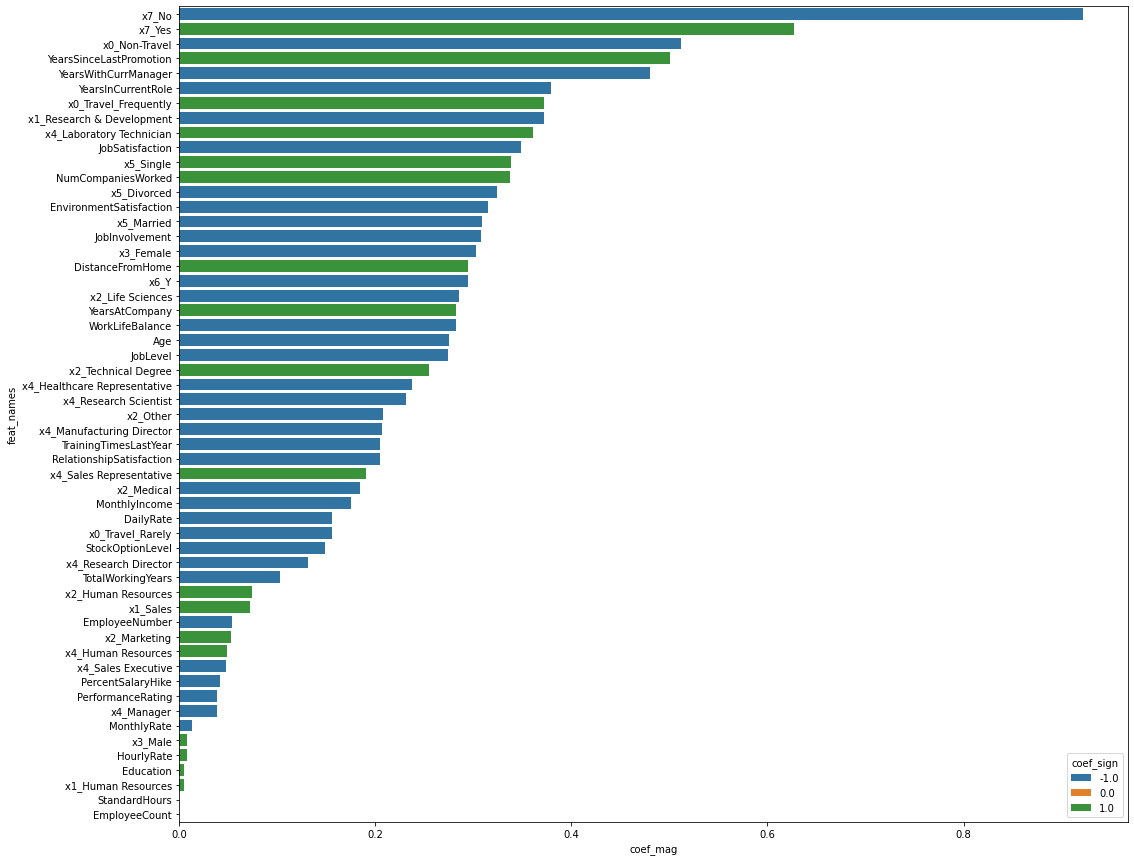

In [1089]:
# TODO: feel free to uncomment and edit the code below to obtain your feature importance graph. 
# Did the graph surprise you? What features did you think were more important?

#get names in correct preproc order
cat_names = grid_search_lr.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names_out()
num_names = grid_search_lr.best_estimator_.named_steps['preproc'].transformers_[1][2]

#create df with vip info
coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'vip': vip_lr})

#get sign and magnitude information
coef_info = coef_info.assign(coef_mag = abs(coef_info['vip']),
                             coef_sign = np.sign(coef_info['vip']))

#sort and plot
coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
plt.figure(figsize = (17,15))
sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False)

## Performance metrics on test data


Here, we can see the performance of the model, which is pretty nice! We can also look into different scores specifically for more insight into the performance.

Logistic

In [1090]:
# TODO: print your classification report of your model
print(classification_report(y_test, grid_search_lr.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

          No       0.91      0.98      0.94       309
         Yes       0.82      0.47      0.60        59

    accuracy                           0.90       368
   macro avg       0.87      0.73      0.77       368
weighted avg       0.89      0.90      0.89       368



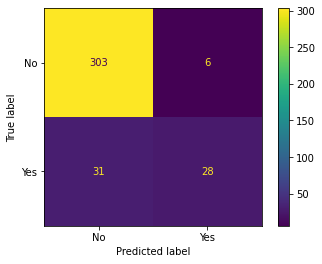

In [1091]:
# TODO: plot the confusion matrix graph
confMatrix_lr = confusion_matrix(y_test, grid_search_lr.best_estimator_.predict(X_test))
confMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=confMatrix_lr, 
                                           display_labels=grid_search_lr.classes_)
confMatrixDisplay.plot()
plt.show()

Gradient

In [1092]:
# TODO: print your classification report of your model
print(classification_report(y_test, grid_search_gb.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

          No       0.89      0.95      0.92       309
         Yes       0.60      0.36      0.45        59

    accuracy                           0.86       368
   macro avg       0.74      0.66      0.68       368
weighted avg       0.84      0.86      0.84       368



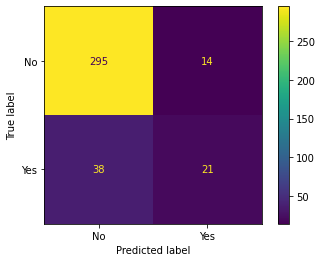

In [1093]:
# TODO: plot the confusion matrix graph
confMatrix_gb = confusion_matrix(y_test, grid_search_gb.best_estimator_.predict(X_test))
confMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=confMatrix_gb, 
                                           display_labels=grid_search_gb.classes_)
confMatrixDisplay.plot()
plt.show()

Random Forest

In [1094]:
# TODO: print your classification report of your model
print(classification_report(y_test, grid_search_rf.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

          No       0.86      0.99      0.92       309
         Yes       0.77      0.17      0.28        59

    accuracy                           0.86       368
   macro avg       0.82      0.58      0.60       368
weighted avg       0.85      0.86      0.82       368



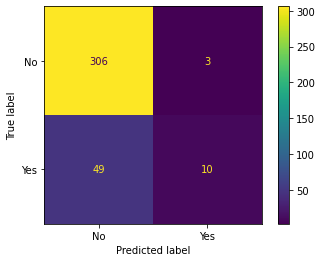

In [1095]:
# TODO: plot the confusion matrix graph
confMatrix_rf = confusion_matrix(y_test, grid_search_rf.best_estimator_.predict(X_test))
confMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=confMatrix_rf, 
                                           display_labels=grid_search_rf.classes_)
confMatrixDisplay.plot()
plt.show()

# Calculate the financial value of your models based on the following costs and benefits

*   Cost of replacing an employee is $120,000 (RC)

*   Cost of intervention $2,000 used on each employee predicted to leave (IC)

*   Intervention success rate is 20% (SR)

**Compare models on value, what is the best model according to your value metric?**


In [1099]:
cost = np.array([[0, 2000], [120000, 2000 - 120000*0.2]])

total_cost = np.multiply(confMatrix_rf, cost).sum()
print('Random Forest =', "${:,}".format(total_cost))

total_cost = np.multiply(confMatrix_gb, cost).sum()
print('Gradient Boost =', "${:,}".format(total_cost))

total_cost = np.multiply(confMatrix_lr, cost).sum()
print('Logistic Regression =', "${:,}".format(total_cost))

Random Forest = $5,666,000.0
Gradient Boost = $4,126,000.0
Logistic Regression = $3,116,000.0


# **Logistic Regression appears to be the best model in this case costing $3,116,000**